### TODO
1. 模型过拟合，加入batchNormalization和dropout
2. 增加LSTM堆叠，提高模型accuracy
3. 按照LSTM的代码格式，修改两个CNN的格式重新训练，训练完保存模型

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils, regularizers
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from tensorflow.keras import backend as K

from utils.data import load_capg_data, CapgDBName, LoadMode

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
K.set_session(session)  # set this TensorFlow session as the default session for Keras

In [2]:
# set const values
weights_file = './models/capg_lstm_weights.h5'
model_file = './models/capg_lstm_model.h5'
window_len = 50
BATCH_SIZE = 128
test_splite = 0.1
EPOCHS = 120

In [3]:
# load capg dba data
x_train, y_train, category = load_capg_data(CapgDBName.dba, LoadMode.sequence)
seg_length = int(x_train.shape[1] / window_len)

x_train = x_train.reshape(x_train.shape[0]*seg_length, window_len, x_train.shape[2])
y_train = y_train.reshape(y_train.shape[0], 1) * np.ones((1, seg_length))
y_train = y_train.flatten()
y_train = utils.to_categorical(y_train - 1, category)

index = np.random.choice(x_train.shape[0], int(x_train.shape[0]*test_splite))
x_test = x_train[index]
y_test = y_train[index]

x_train = np.delete(x_train, index, axis=0)
y_train = np.delete(y_train, index, axis=0)

print('train set')
print(x_train.shape)
print(y_train.shape)
print('test set')
print(x_test.shape)
print(y_test.shape)

train set
(26069, 50, 128)
(26069, 8)
test set
(2880, 50, 128)
(2880, 8)


In [4]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(window_len, 128), dropout=0.2,
               activity_regularizer=regularizers.l2(l=0.01), name='lstm_1'))
# model.add(LSTM(256, activation='relu', return_sequences=True, name='lstm_2'))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(256, activation='relu', name='lstm_3'))  # return a single vector of dimension 32
model.add(Dense(8, activation='softmax', name='output'))

if os.path.exists(model_file):
    print('load weights from a trained model')
    model.load_weights(model_file, by_name=True)
else:
    print('train a new model')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
train a new model


In [5]:
sgd = SGD(clipnorm=1, clipvalue=0.5, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
output (Dense)               (None, 8)                 2056      
Total params: 396,296
Trainable params: 396,296
Non-trainable params: 0
_________________________________________________________________


In [6]:
# tb_callback = TensorBoard(log_dir='./logs/lstm/',
#                           histogram_freq=1,
#                           batch_size=32,
#                           write_grads=True,
#                           update_freq='batch')

In [7]:
def learning_rate_tuner(epoch):
    lr = 0.1
    if 40 <= epoch < 80:
        lr = 0.01
    elif epoch >= 80:
        lr = 0.001
    return lr

lr_scheduler = LearningRateScheduler(learning_rate_tuner)

In [8]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[lr_scheduler])

Train on 26069 samples, validate on 2880 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/120
26069/26069 [==============================] - 8s 311us/sample - loss: 2.0700 - acc: 0.1371 - val_loss: 2.0615 - val_acc: 0.1528
Epoch 2/120
26069/26069 [==============================] - 8s 303us/sample - loss: 2.0570 - acc: 0.1516 - val_loss: 2.0483 - val_acc: 0.1649
Epoch 3/120
26069/26069 [==============================] - 8s 302us/sample - loss: 2.0395 - acc: 0.1649 - val_loss: 2.0756 - val_acc: 0.1365
Epoch 4/120
26069/26069 [==============================] - 8s 304us/sample - loss: 2.0265 - acc: 0.1802 - val_loss: 1.9674 - val_acc: 0.2083
Epoch 5/120
26069/26069 [==============================] - 8s 304us/sample - loss: 2.0201 - acc: 0.1896 - val_loss: 1.9461 - val_acc: 0.2139
Epoch 6/120
26069/26069 [==============================] - 8s 305us/sample - loss: 1.9318 - acc: 0.2086 - val_loss: 1.9146 - val_acc: 0.2219
Epoch 7/120
26069/26069 [==============================] 

26069/26069 [==============================] - 8s 302us/sample - loss: 0.5187 - acc: 0.8126 - val_loss: 0.5245 - val_acc: 0.8118
Epoch 57/120
26069/26069 [==============================] - 8s 301us/sample - loss: 0.5143 - acc: 0.8189 - val_loss: 0.5259 - val_acc: 0.8115
Epoch 58/120
26069/26069 [==============================] - 8s 302us/sample - loss: 0.5062 - acc: 0.8180 - val_loss: 0.5088 - val_acc: 0.8184
Epoch 59/120
26069/26069 [==============================] - 8s 303us/sample - loss: 0.5016 - acc: 0.8226 - val_loss: 0.5130 - val_acc: 0.8198
Epoch 60/120
26069/26069 [==============================] - 8s 304us/sample - loss: 0.5008 - acc: 0.8224 - val_loss: 0.5024 - val_acc: 0.8267
Epoch 61/120
26069/26069 [==============================] - 8s 302us/sample - loss: 0.4903 - acc: 0.8265 - val_loss: 0.5003 - val_acc: 0.8274
Epoch 62/120
26069/26069 [==============================] - 8s 304us/sample - loss: 0.4927 - acc: 0.8267 - val_loss: 0.5210 - val_acc: 0.8118
Epoch 63/120
26069/

Epoch 114/120
26069/26069 [==============================] - 8s 303us/sample - loss: 0.3740 - acc: 0.8738 - val_loss: 0.4196 - val_acc: 0.8576
Epoch 115/120
26069/26069 [==============================] - 8s 303us/sample - loss: 0.3759 - acc: 0.8726 - val_loss: 0.4206 - val_acc: 0.8608
Epoch 116/120
26069/26069 [==============================] - 8s 302us/sample - loss: 0.3717 - acc: 0.8749 - val_loss: 0.4214 - val_acc: 0.8608
Epoch 117/120
26069/26069 [==============================] - 8s 304us/sample - loss: 0.3734 - acc: 0.8730 - val_loss: 0.4220 - val_acc: 0.8618
Epoch 118/120
26069/26069 [==============================] - 8s 304us/sample - loss: 0.3793 - acc: 0.8717 - val_loss: 0.4194 - val_acc: 0.8635
Epoch 119/120
26069/26069 [==============================] - 8s 302us/sample - loss: 0.3738 - acc: 0.8733 - val_loss: 0.4187 - val_acc: 0.8622
Epoch 120/120
26069/26069 [==============================] - 8s 302us/sample - loss: 0.3751 - acc: 0.8738 - val_loss: 0.4195 - val_acc: 0.8615

In [9]:
model.save_weights(weights_file)
model.save(model_file)
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


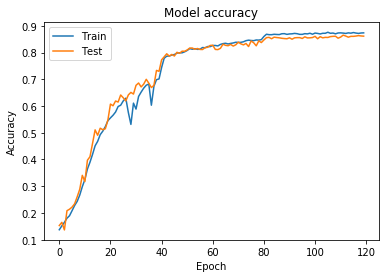

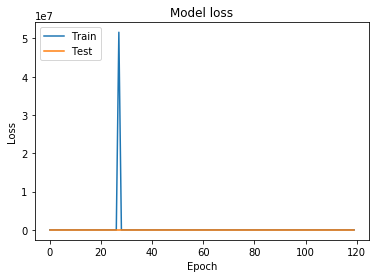

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./figures/lstm_acc.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./figures/lstm_loss.png')
plt.show()